In [1]:
!python -m pip install xgboost

In [12]:
!python -m pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from utils import LoadRumoursDataset,Load_Rumours_Dataset_filtering_since_first_post
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
#mlflow.set_experiment("Xgboost experiments 2024-09-26 SMOTE")

In [3]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


### SMOTE APPROACH

In [11]:
dataset_generator  = LoadRumoursDatasetFilterNodeonTestV3(file_path_replies, file_path_posts,time_cut=24*3*60)
dataset_generator.load_data()
dataset_generator.process_data()
train_dataset, test_dataset = dataset_generator.get_final_dataframes()

In [12]:
train_dataset.shape

(1401, 10)

In [13]:
test_dataset.shape

(601, 10)

In [14]:
X_train  = train_dataset.drop(columns=['rumour'])
X_train = np.hstack([X_train.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_train.embeddings_avg.tolist()))])


X_test  = test_dataset.drop(columns=['rumour'])
X_test = np.hstack([X_test.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test.embeddings_avg.tolist()))])

#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y_train =train_dataset['rumour']
y_test =test_dataset['rumour']

In [15]:
print(y_train.sum(),y_train.shape)

313 (1401,)


In [16]:
print(y_test.sum(),y_test.shape)

134 (601,)


In [17]:
# Apply SMOTE to the features without embeddings
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
X_resampled.shape

(2176, 108)

In [19]:
print(y_resampled.sum(),y_resampled.shape)

1088 (2176,)


#### Hyperparameter tunning

In [20]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
     'max_depth': [3, 4, 5, 6],
    'learning_rate': np.linspace(0.001, 0.1, 20),
    'n_estimators': [20,50, 100, 150, 200]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1')


In [21]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_resampled, y_resampled)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.07915789473684211}
Best score:  0.9423937862571574


In [22]:
best_params = random_search.best_params_

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    

    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    

    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg



In [27]:
best_params={
             'n_estimators': 50, 
             'max_depth': 3, 
             'learning_rate': 0.05, 
       }

In [28]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
modelfit(final_model,X_resampled, y_resampled,X_test,y_test)


Model Report Train
AUC Score : 0.972710
Accuracy : 0.9035
Precision : 0.8798
Recall : 0.934743

Model Report Test
AUC Score : 0.893813
Accuracy : 0.8203
Precision : 0.5657
Recall : 0.835821


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.910857 | Std - 0.03241332 | Min - 0.8669725 | Max - 0.9493088


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [30]:
modelfit(final_model,X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.959882
Accuracy : 0.8794
Precision : 0.6706
Recall : 0.904153

Model Report Test
AUC Score : 0.893813
Accuracy : 0.8203
Precision : 0.5657
Recall : 0.835821


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.5654378 | Std - 0.1080148 | Min - 0.4126984 | Max - 0.6984127


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### Without SMOTE

In [31]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [32]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.968580
Accuracy : 0.9172
Precision : 0.8745
Recall : 0.734824

Model Report Test
AUC Score : 0.901403
Accuracy : 0.8552
Precision : 0.7423
Recall : 0.537313


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.5654378 | Std - 0.1080148 | Min - 0.4126984 | Max - 0.6984127


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### SMOTE and generic Xgboost pipeline

In [35]:
# Train the final model with the best hyperparameters
params =   {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.5
}
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **params
)
final_model.fit(X_resampled, y_resampled)


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

In [36]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.3192524 | Std - 0.04691517 | Min - 0.2419355 | Max - 0.3809524


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

#### General Parameters:

* objective: "binary:logistic" (since it's a binary classification problem)
*  eval_metric: "logloss" (logarithmic loss is a good measure for classification)
  
#### Tree Booster Parameters:
* max_depth: 4 (shallower trees to prevent overfitting)
* learning_rate: 0.05 (a lower learning rate helps the model generalize better)
* n_estimators: 100 (start with fewer trees to prevent overfitting on a small dataset)
* subsample: 0.8 (use 80% of the data for each boosting round to introduce randomness)
* colsample_bytree: 0.8 (use 80% of the features, useful with high-dimensional embeddings)

#### Regularization Parameters:
* gamma: 0.1 (penalty for additional leaf nodes, controls tree complexity)
* min_child_weight: 1 (controls the minimum sum of instance weight in a child, useful for preventing overfitting)
* lambda: 1 (L2 regularization to reduce overfitting)
* alpha: 0.5 (L1 regularization for feature selection)
  


In [41]:
def modelfit(alg, X_train, y_train, X_test, y_test, printFeatureImportance=True):
    with mlflow.start_run():
        # Fit the algorithm on the data
        #alg.fit(X_resampled, y_resampled)
            
        # Predict training set:
        dtrain_predictions = alg.predict(X_train)
        dtrain_predprob = alg.predict_proba(X_train)[:, 1]

        # Predict test set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:, 1]

        # Log model parameters
        mlflow.log_params(alg.get_params())

        # Log metrics for Train
        mlflow.log_metric("train_auc", roc_auc_score(y_train, dtrain_predprob))
        mlflow.log_metric("train_accuracy", accuracy_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_precision", precision_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_recall", recall_score(y_train, dtrain_predictions))

        # Log metrics for Test
        mlflow.log_metric("test_auc", roc_auc_score(y_test, dtest_predprob))
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, dtest_predictions))
        mlflow.log_metric("test_precision", precision_score(y_test, dtest_predictions))
        mlflow.log_metric("test_recall", recall_score(y_test, dtest_predictions))

        # Print model report for Train
        print("\nModel Report Train")
        print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
        print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
        print("Recall : %f" % recall_score(y_train, dtrain_predictions))

      

        # Log confusion matrix for Train
        #train_cm = confusion_matrix(y_train, dtrain_predictions)
        #mlflow.log_artifact(plot_confusion_matrix(train_cm, "Train"))

        # Print model report for Test
        print("\nModel Report Test")
        print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
        print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
        print("Recall : %f" % recall_score(y_test, dtest_predictions))


        # Log the model with input example
        #input_example = X_train[0:1]   # Use the first row of X_train as an example
        #mlflow.sklearn.log_model(alg, "model", input_example=input_example)
        mlflow.log_metric("time_cut", time_cut)
    
    # Explicitly end the MLflow run
    mlflow.end_run()

    return alg



In [38]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("Xgboost SMOTE Filter Node on Test  2024-10-29 10 min-3days")

2024/10/29 23:44:21 INFO mlflow.tracking.fluent: Experiment with name 'Xgboost SMOTE Filter Node on Test  2024-10-29 10 min-3days' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/43', creation_time=1730245461089, experiment_id='43', last_update_time=1730245461089, lifecycle_stage='active', name='Xgboost SMOTE Filter Node on Test  2024-10-29 10 min-3days', tags={}>

In [42]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(14,24*3*60,10):
    print(time_cut)
    dataset_generator  = LoadRumoursDatasetFilterNodeonTestV3(file_path_replies, file_path_posts,time_cut=time_cut)
    dataset_generator.load_data()
    dataset_generator.process_data()
    train_dataset, test_dataset = dataset_generator.get_final_dataframes()

    X_train  = train_dataset.drop(columns=['rumour'])
    X_train = np.hstack([X_train.drop(columns=['embeddings_avg']).values, \
                             np.array(pd.DataFrame(X_train.embeddings_avg.tolist()))])


    X_test  = test_dataset.drop(columns=['rumour'])
    X_test = np.hstack([X_test.drop(columns=['embeddings_avg']).values, \
                            np.array(pd.DataFrame(X_test.embeddings_avg.tolist()))])

    #X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
    y_train =train_dataset['rumour']
    y_test =test_dataset['rumour']
        
    #if time_cut_posts >20:

    smote = SMOTE(random_state=42,sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    final_model = xgb.XGBClassifier(
        eval_metric='logloss',
        **params
    )
        
    final_model.fit(X_resampled, y_resampled)
         
        
    modelfit(final_model,  X_train, y_train,X_test,y_test)

14

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.833333
Accuracy : 0.6
Precision : 0.6667
Recall : 0.666667
24

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.875000
Accuracy : 0.7333
Precision : 0.75
Recall : 0.750000
34

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909091
Accuracy : 0.8
Precision : 0.8462
Recall : 0.785714
44

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.876068
Accuracy : 0.8065
Precision : 0.8333
Recall : 0.833333
54

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.866873
Accuracy : 0.8056
Precision : 0.8
Recall : 0.842105
64

Model Report Train
AUC Score : 0.9790


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910031
Accuracy : 0.8657
Precision : 0.566
Recall : 0.833333
454

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910031
Accuracy : 0.8657
Precision : 0.566
Recall : 0.833333
464

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910031
Accuracy : 0.8657
Precision : 0.566
Recall : 0.833333
474

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910031
Accuracy : 0.8657
Precision : 0.566
Recall : 0.833333
484

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910031
Accuracy : 0.8657
Precision : 0.566
Recall : 0.833333
494

Model Report Train
AUC Score 


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909112
Accuracy : 0.8661
Precision : 0.5932
Recall : 0.813953
884

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909112
Accuracy : 0.8661
Precision : 0.5932
Recall : 0.813953
894

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909112
Accuracy : 0.8661
Precision : 0.5932
Recall : 0.813953
904

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909112
Accuracy : 0.8661
Precision : 0.5932
Recall : 0.813953
914

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.909112
Accuracy : 0.8661
Precision : 0.5932
Recall : 0.813953
924

Model Report Train
AUC S


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.914894
Accuracy : 0.868
Precision : 0.6094
Recall : 0.829787
1314

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.916522
Accuracy : 0.8711
Precision : 0.6094
Recall : 0.829787
1324

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.916920
Accuracy : 0.8716
Precision : 0.6094
Recall : 0.829787
1334

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.916700
Accuracy : 0.8726
Precision : 0.6094
Recall : 0.829787
1344

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.915583
Accuracy : 0.8707
Precision : 0.6
Recall : 0.829787
1354

Model Report Train
AUC 


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905510
Accuracy : 0.8627
Precision : 0.5349
Recall : 0.779661
1734

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906061
Accuracy : 0.8638
Precision : 0.5349
Recall : 0.779661
1744

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906198
Accuracy : 0.8629
Precision : 0.5287
Recall : 0.779661
1754

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906755
Accuracy : 0.8643
Precision : 0.5287
Recall : 0.779661
1764

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906879
Accuracy : 0.8628
Precision : 0.5227
Recall : 0.779661
1774

Model Report Train



Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906392
Accuracy : 0.8631
Precision : 0.5169
Recall : 0.779661
2154

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906392
Accuracy : 0.8631
Precision : 0.5169
Recall : 0.779661
2164

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906392
Accuracy : 0.8631
Precision : 0.5169
Recall : 0.779661
2174

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906392
Accuracy : 0.8631
Precision : 0.5169
Recall : 0.779661
2184

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.906392
Accuracy : 0.8631
Precision : 0.5169
Recall : 0.779661
2194

Model Report Train



Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905238
Accuracy : 0.861
Precision : 0.5169
Recall : 0.766667
2574

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905238
Accuracy : 0.861
Precision : 0.5169
Recall : 0.766667
2584

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905238
Accuracy : 0.861
Precision : 0.5169
Recall : 0.766667
2594

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905238
Accuracy : 0.861
Precision : 0.5169
Recall : 0.766667
2604

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.905238
Accuracy : 0.861
Precision : 0.5169
Recall : 0.766667
2614

Model Report Train
AUC S


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.921167
Accuracy : 0.8654
Precision : 0.6261
Recall : 0.782609
2994

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.923098
Accuracy : 0.8674
Precision : 0.6387
Recall : 0.791667
3004

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.920639
Accuracy : 0.8654
Precision : 0.6371
Recall : 0.797980
3014

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.917938
Accuracy : 0.8607
Precision : 0.625
Recall : 0.800000
3024

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.910812
Accuracy : 0.8569
Precision : 0.6279
Recall : 0.778846
3034

Model Report Train
A


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891414
Accuracy : 0.818
Precision : 0.5654
Recall : 0.805970
3414

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891414
Accuracy : 0.818
Precision : 0.5654
Recall : 0.805970
3424

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891414
Accuracy : 0.818
Precision : 0.5654
Recall : 0.805970
3434

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891414
Accuracy : 0.818
Precision : 0.5654
Recall : 0.805970
3444

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891414
Accuracy : 0.818
Precision : 0.5654
Recall : 0.805970
3454

Model Report Train
AUC S


Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
3834

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
3844

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
3854

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
3864

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
3874

Model Report Train



Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
4254

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
4264

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
4274

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
4284

Model Report Train
AUC Score : 0.979054
Accuracy : 0.9136
Precision : 0.7388
Recall : 0.948882

Model Report Test
AUC Score : 0.891751
Accuracy : 0.8186
Precision : 0.5654
Recall : 0.805970
4294

Model Report Train


In [43]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
import seaborn as sns

# Get the experiment ID or name
experiment_name = "Xgboost SMOTE Filter Node on Test  2024-10-29 10 min-3days"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


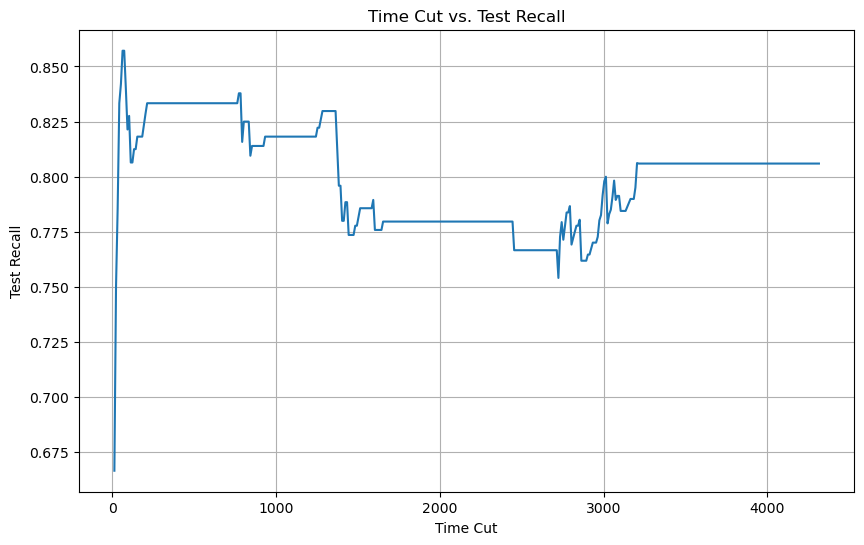

In [44]:

# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

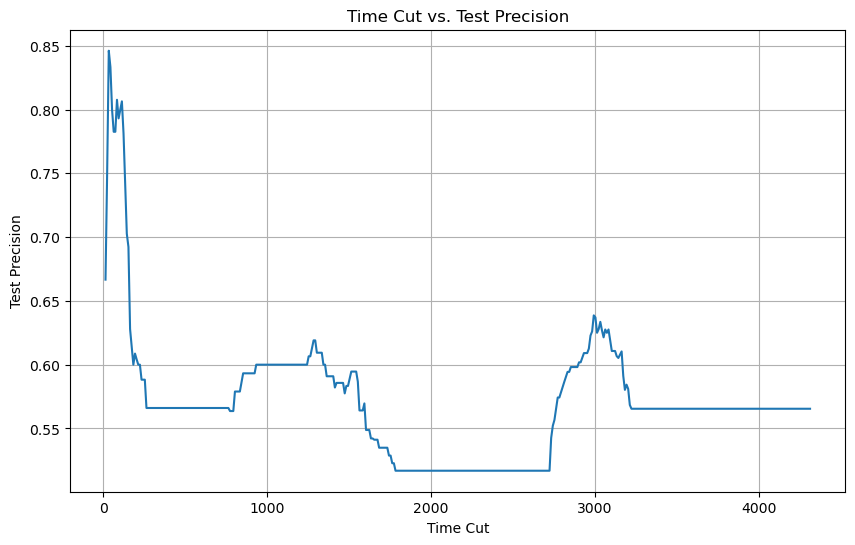

In [45]:
    # Ensure the metrics are numeric
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_precision'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()